In [1]:
!pip install tf_nightly_gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 411.0MB 61kB/s 
     |████████████████████████████████| 3.8MB 37.2MB/s 
     |████████████████████████████████| 450kB 46.5MB/s 
     |████████████████████████████████| 81kB 2.4MB/s 
  Found existing installation: tensorflow-hub 0.6.0
    Uninstalling tensorflow-hub-0.6.0:
      Successfully uninstalled tensorflow-hub-0.6.0
     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt

import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224
model = tf.keras.Sequential(
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
)

In [6]:
import numpy as np
import PIL.Image as Image 

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

65536/61306 [================================] - 0s 0us/step


(224, 224, 3)

In [9]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

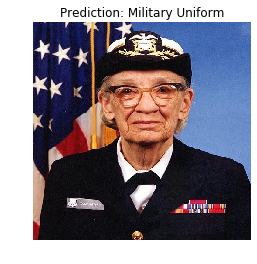

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                                      'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [17]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label 

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [19]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Egyptian cat', 'tabby', 'Egyptian cat', 'Great Dane',
       'German shepherd', 'golden retriever', 'golden retriever', 'boxer',
       'Persian cat', 'Egyptian cat', 'groenendael', 'pug', 'ox',
       'Egyptian cat', 'Siamese cat', 'Yorkshire terrier', 'Great Dane',
       'papillon', 'lynx', 'tiger cat', 'otterhound', 'Arctic fox',
       'Egyptian cat', 'wombat', 'groenendael', 'collie', 'tiger cat',
       'Labrador retriever', 'lynx', 'Appenzeller',
       'flat-coated retriever', 'Egyptian cat'], dtype='<U30')

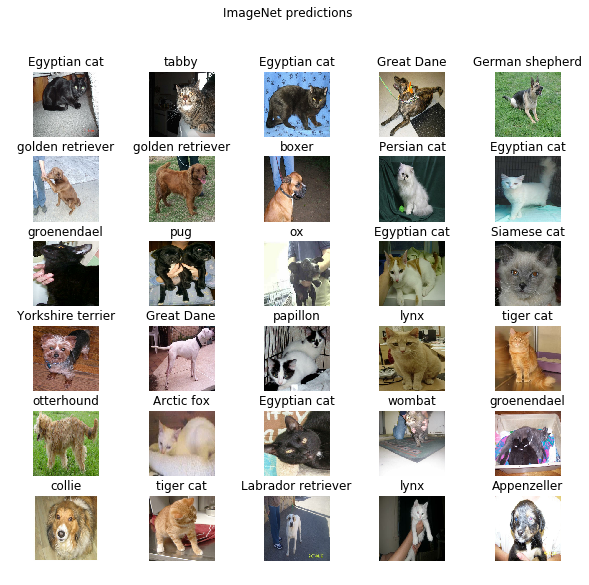

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [23]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

feature_extractor.trainable = False

(32, 1280)


In [24]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 6
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 2057s 4s/step - loss: 0.2246 - acc: 0.9438 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
143/145 [============================>.] - ETA: 6s - loss: 0.1795 - acc: 0.9620